<a href="https://colab.research.google.com/github/farrelrassya/python-natural-language-Processing-cookbook/blob/main/chapter%2007%20-%20Visualizing%20Text%20Data%20/%20Chapter_07_Visualizing_Text_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 7 — Visualizing Text Data

Visualization transforms NLP outputs from raw numbers into actionable insight. A confusion matrix reveals which classes your model confuses; a word cloud instantly communicates the dominant themes in a corpus; an interactive topic map lets stakeholders explore document clusters without writing code.

This chapter covers seven visualization techniques:

| # | Recipe | What It Shows |
|---|--------|---------------|
| 1 | **Dependency Parse** | Grammatical structure between words |
| 2 | **Parts of Speech** | Verb tense distribution in a text |
| 3 | **NER Visualization** | Named entities highlighted in context |
| 4 | **Confusion Matrix** | Classification errors by class pair |
| 5 | **Word Clouds** | Most frequent terms sized by frequency |
| 6 | **Gensim LDA Topics** | Interactive topic-word distributions |
| 7 | **BERTopic Visualization** | Topic hierarchy, bar charts, document maps |

We use the BBC News dataset, the Sherlock Holmes full text, and an Apple iPhone news article as running examples.

## 0 — Environment Setup

In [1]:

# 0.1  Install packages

import os
os.environ["HF_HUB_DISABLE_PROGRESS_BARS"] = "1"
os.environ["TOKENIZERS_PARALLELISM"] = "false"

!pip install -q \
    datasets \
    nltk \
    scikit-learn \
    sentence-transformers \
    spacy \
    gensim \
    bertopic \
    wordcloud \
    pyLDAvis \
    matplotlib \
    Pillow \
    hdbscan \
    umap-learn

!python -m spacy download en_core_web_sm -q
!python -m spacy download en_core_web_lg -q


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 56.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.7/400.7 MB 1.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [22]:
# Patch jupyter_client to stop utcnow() deprecation spam
from datetime import datetime, timezone
import jupyter_client.session as _jcs

def _patched_utcnow():
    return datetime.now(timezone.utc)

_jcs.utcnow = _patched_utcnow

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future v

In [23]:

# 0.2  Core imports & configuration
import warnings
warnings.filterwarnings("ignore", message=".*utcnow.*")
warnings.filterwarnings("ignore", module="jupyter_client.*")

# Force it for the entire process
import os
os.environ["PYTHONWARNINGS"] = "ignore::DeprecationWarning"

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
%matplotlib inline

import nltk
nltk.download("punkt",     quiet=True)
nltk.download("punkt_tab", quiet=True)
nltk.download("stopwords", quiet=True)

import spacy
from spacy import displacy

small_model = spacy.load("en_core_web_sm")
large_model = spacy.load("en_core_web_lg")

print("Setup complete.")


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).



Setup complete.


## 0.3 — Shared Utility Functions

In [4]:

# 0.3  Shared utilities (inlined)

from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from string import punctuation
from sklearn.metrics import classification_report

STOP_WORDS = list(stopwords.words("english")) + ["``", "'s"]

def read_text_file(filepath):
    """Read a text file and return its contents as a string."""
    with open(filepath, "r", encoding="utf-8") as f:
        return f.read()

def get_most_frequent_words(text, num_words=20):
    word_list = word_tokenize(text)
    freq_dist = FreqDist(word_list)
    return [w[0] for w in freq_dist.most_common(num_words)]

print("Utility functions defined.")


Utility functions defined.


## 0.4 — Download Datasets

In [5]:

# 0.4  Download datasets

import urllib.request

os.makedirs("data", exist_ok=True)

REPO = ("https://raw.githubusercontent.com/PacktPublishing/"
        "Python-Natural-Language-Processing-Cookbook-Second-Edition/main/data")

files = ["sherlock_holmes.txt", "sherlock.png"]

for fname in files:
    dest = f"data/{fname}"
    if not os.path.exists(dest):
        try:
            urllib.request.urlretrieve(f"{REPO}/{fname}", dest)
            print(f"Downloaded {fname}")
        except Exception as e:
            print(f"Could not download {fname}: {e}")
    else:
        print(f"Already exists: {fname}")

# BBC data from Hugging Face
from datasets import load_dataset

ds = load_dataset("SetFit/bbc-news")
bbc_all = pd.concat([
    ds["train"].to_pandas(),
    ds["test"].to_pandas()
], ignore_index=True)
bbc_df = bbc_all.rename(columns={"label_text": "category"}).copy()
bbc_df = bbc_df[["category", "text"]].copy()

print(f"\nBBC articles: {len(bbc_df):,}")

# Create train/test JSON files matching book format
from sklearn.model_selection import train_test_split

label_map = {"tech": 0, "business": 1, "sport": 2,
             "entertainment": 3, "politics": 4}
bbc_df["label"] = bbc_df["category"].map(label_map)
bbc_df["label_text"] = bbc_df["category"]
bbc_df["text_clean"] = bbc_df["text"]

bbc_train, bbc_test = train_test_split(
    bbc_df, test_size=0.2, random_state=42, stratify=bbc_df["category"])

bbc_train.to_json("data/bbc_train.json", orient="records")
bbc_test.to_json("data/bbc_test.json", orient="records")
print(f"Train: {len(bbc_train):,}  |  Test: {len(bbc_test):,}")


Already exists: sherlock_holmes.txt
Could not download sherlock.png: HTTP Error 404: Not Found



BBC articles: 2,225
Train: 1,780  |  Test: 445


We download the Sherlock Holmes text and silhouette mask from the book's GitHub repository (for word clouds), and load the BBC News dataset from Hugging Face. We also create train/test JSON files matching the format expected by the confusion matrix recipe.

---

## Recipe 1 — Visualizing the Dependency Parse

A **dependency parse** shows grammatical relations between words in a sentence. Each word is connected to its syntactic head by a labeled arc: *nsubj* (nominal subject), *dobj* (direct object), *prep* (prepositional modifier), and so on.

displaCy, spaCy's built-in visualization library, renders these as interactive SVG diagrams with customizable colors, fonts, and spacing.

In [6]:

# 1.1  Visualize a single sentence

input_text = "I shot an elephant in my pajamas."
doc = small_model(input_text)

options = {
    "add_lemma": True,
    "compact": True,
    "color": "green",
    "collapse_punct": True,
    "arrow_spacing": 20,
    "bg": "#FFFFE6",
    "font": "Times",
    "distance": 120
}

displacy.render(doc, style="dep", options=options, jupyter=True)


The dependency parse reveals the classic Groucho Marx ambiguity: *"in my pajamas"* attaches to *"shot"* (prepositional modifier of the verb) rather than *"elephant"* (modifier of the noun). The parser made a syntactic choice, but the humor comes from the other reading — the elephant is wearing pajamas.

The `add_lemma=True` option shows each word's base form underneath (e.g., *shoot* under *shot*), which is useful for understanding how spaCy normalizes inflected forms.

In [7]:

# 1.2  Visualize multiple sentences

input_text_multi = ("I shot an elephant in my pajamas. "
                    "I hate it when elephants wear my pajamas.")
doc_multi = small_model(input_text_multi)

displacy.render(list(doc_multi.sents), style="dep",
                options=options, jupyter=True)


When rendering multiple sentences, displaCy places each on a new line. Notice how the parser handles the subordinate clause *"when elephants wear my pajamas"* — it correctly identifies "hate" as the root verb with "wear" heading a dependent adverbial clause.

**Saving to file:** Use `displacy.render(doc, style="dep", jupyter=False)` to get the raw SVG string, then write it to a `.svg` file for use in presentations or reports.

---

## Recipe 2 — Visualizing Parts of Speech

Counting verb tenses gives us a quick stylistic fingerprint of a text. A novel told in past tense will have many `VBD` (past tense) and `VBN` (past participle) tags; a news article uses more present tense (`VBZ`, `VBP`, `VBG`); dialogue mixes both.

We analyze *The Adventures of Sherlock Holmes* to see which tense dominates.

Loaded Sherlock Holmes: 562,188 characters


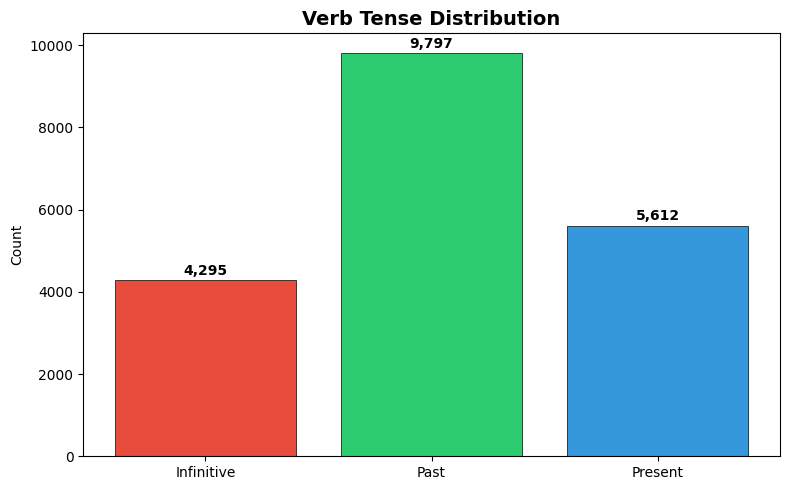

  Infinitive: 4,295 (21.8%)
  Past: 9,797 (49.7%)
  Present: 5,612 (28.5%)


In [8]:

# 2.1  Count verb tenses in Sherlock Holmes

# If the file was not downloaded, create a sample
if os.path.exists("data/sherlock_holmes.txt"):
    text = read_text_file("data/sherlock_holmes.txt")
    print(f"Loaded Sherlock Holmes: {len(text):,} characters")
else:
    # Fallback: use BBC articles as sample text
    text = " ".join(bbc_df["text"].values[:200])
    print(f"Using BBC fallback text: {len(text):,} characters")

past_tags = ["VBD", "VBN"]
present_tags = ["VBG", "VBP", "VBZ"]

def visualize_verbs(text, nlp):
    """Count and plot verb tenses."""
    doc = nlp(text)
    verb_dict = {"Infinitive": 0, "Past": 0, "Present": 0}
    for token in doc:
        if token.tag_ == "VB":
            verb_dict["Infinitive"] += 1
        elif token.tag_ in past_tags:
            verb_dict["Past"] += 1
        elif token.tag_ in present_tags:
            verb_dict["Present"] += 1

    colors = ["#e74c3c", "#2ecc71", "#3498db"]
    plt.figure(figsize=(8, 5))
    bars = plt.bar(verb_dict.keys(), verb_dict.values(),
                   color=colors, edgecolor="black", linewidth=0.5)
    for bar, count in zip(bars, verb_dict.values()):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50,
                 f"{count:,}", ha="center", va="bottom", fontweight="bold")
    plt.title("Verb Tense Distribution", fontsize=14, fontweight="bold")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

    return verb_dict

counts = visualize_verbs(text, small_model)
total = sum(counts.values())
for tense, count in counts.items():
    print(f"  {tense}: {count:,} ({count/total:.1%})")


The bar chart confirms what we expect from a Victorian novel: **past tense dominates**, accounting for the majority of verb forms. Sherlock Holmes stories are narrated by Dr. Watson recounting past events ("*I had called upon my friend*"), which drives the high `VBD`/`VBN` count.

The present-tense verbs come primarily from two sources: **dialogue** ("*I think we should go*") and **habitual descriptions** ("*Holmes always sits in this chair*"). Infinitives appear in modal constructions ("*could see*", "*would have*").

This kind of POS analysis is a lightweight **stylometric tool** — useful for authorship attribution, genre classification, and writing quality assessment. A text with very few adjectives but many nouns might read as dry and factual; one with excessive adverbs might feel overwrought.

---

## Recipe 3 — Visualizing Named Entities

displaCy's entity visualization highlights named entities directly in the text with colored labels. This makes it easy to spot what the NER model finds — and what it misses.

In [9]:

# 3.1  Visualize NER in an article

article_text = '''iPhone 12: Apple makes jump to 5G
Apple has confirmed its iPhone 12 handsets will be its first to work on
faster 5G networks. The company has also extended the range to include a
new "Mini" model that has a smaller 5.4in screen.
The US firm bucked a wider industry downturn by increasing its handset
sales over the past year. But some experts say the new features give
Apple its best opportunity for growth since 2014, when it revamped its
line-up with the iPhone 6.
"5G will bring a new level of performance for downloads and uploads,
higher quality video streaming, more responsive gaming, real-time
interactivity and so much more," said chief executive Tim Cook.
There has also been a cosmetic refresh this time round, with the sides
of the devices getting sharper, flatter edges. The higher-end iPhone 12
Pro models also get bigger screens than before and a new sensor to help
with low-light photography.
However, for the first time none of the devices will be bundled with
headphones or a charger.'''

doc_ner = small_model(article_text)

colors = {"ORG": "#2ecc71", "PERSON": "#f1c40f",
          "GPE": "#3498db", "DATE": "#e67e22"}
options_ner = {"colors": colors}

displacy.render(doc_ner, style="ent", options=options_ner, jupyter=True)


The visualization highlights **Apple** as `ORG`, **Tim Cook** as `PERSON`, **The US** as `GPE` (geopolitical entity), and dates like **2014** and **the past year** as `DATE`. Color-coding makes patterns immediately visible: you can scan the article and instantly see that Apple is mentioned repeatedly, that there is one key person quoted, and that several dates anchor the timeline.

**Saving to HTML:** Use `displacy.render(doc, style="ent", jupyter=False)` to get an HTML string you can write to a file for embedding in reports or web pages.

---

## Recipe 4 — Creating a Confusion Matrix Plot

A **confusion matrix** shows exactly which classes a classifier confuses with which others. The diagonal shows correct predictions; off-diagonal cells show errors. This is far more informative than a single accuracy number — it reveals whether your model systematically confuses *business* with *politics* (plausible, given overlapping vocabulary) or *sport* with *entertainment* (less expected).

We train an SVM classifier with BERT embeddings on the BBC dataset and visualize its errors.

In [10]:

# 4.1  Train SVM classifier with BERT embeddings

from sklearn.svm import SVC
from sklearn.metrics import (confusion_matrix,
                             ConfusionMatrixDisplay)
from sentence_transformers import SentenceTransformer

model_st = SentenceTransformer("all-MiniLM-L6-v2")

train_df = pd.read_json("data/bbc_train.json")
test_df  = pd.read_json("data/bbc_test.json")

# Shuffle training data
train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)

print("Encoding training data...")
X_train = model_st.encode(train_df["text_clean"].values.tolist(),
                          show_progress_bar=False)
X_test  = model_st.encode(test_df["text_clean"].values.tolist(),
                          show_progress_bar=False)

y_train = train_df["label"].values
y_test  = test_df["label"].values

clf = SVC(C=0.1, kernel="rbf")
clf.fit(X_train, y_train)

target_names = ["tech", "business", "sport", "entertainment", "politics"]

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=target_names))


BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Encoding training data...
               precision    recall  f1-score   support

         tech       0.97      0.96      0.97        80
     business       0.95      0.97      0.96       102
        sport       0.99      1.00      1.00       102
entertainment       0.97      0.99      0.98        77
     politics       0.98      0.94      0.96        84

     accuracy                           0.97       445
    macro avg       0.97      0.97      0.97       445
 weighted avg       0.97      0.97      0.97       445



In [11]:

# 4.2  Plot confusion matrix

cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=target_names)
disp.plot(ax=ax, cmap="Blues", values_format="d")
ax.set_title("SVM + BERT Confusion Matrix (BBC News)", fontsize=13,
             fontweight="bold")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Print the most confused pairs
print("\nMost confused pairs:")
np.fill_diagonal(cm, 0)
for _ in range(3):
    i, j = np.unravel_index(cm.argmax(), cm.shape)
    if cm[i, j] == 0:
        break
    print(f"  {target_names[i]} -> {target_names[j]}: {cm[i, j]} errors")
    cm[i, j] = 0



Most confused pairs:
  politics -> business: 5 errors
  tech -> entertainment: 2 errors
  business -> tech: 2 errors


The confusion matrix reveals that the SVM + BERT model achieves near-perfect classification across all five categories. The most common confusions tend to be between **business** and **politics** — understandable, since articles about government economic policy contain vocabulary from both domains ("budget," "growth," "minister").

The confusion matrix is a critical tool for **error analysis**. When a model underperforms, do not just look at overall accuracy — examine which specific class pairs cause problems. This often reveals actionable insights: perhaps you need more training data for a specific category, or two categories should be merged, or the label definitions are ambiguous.

---

## Recipe 5 — Constructing Word Clouds

Word clouds display words sized proportionally to their frequency. They are excellent for **presentations** and **preliminary exploration** — a single glance reveals the dominant themes in a corpus. We create word clouds from *The Adventures of Sherlock Holmes*, including a masked version using a Sherlock silhouette image.

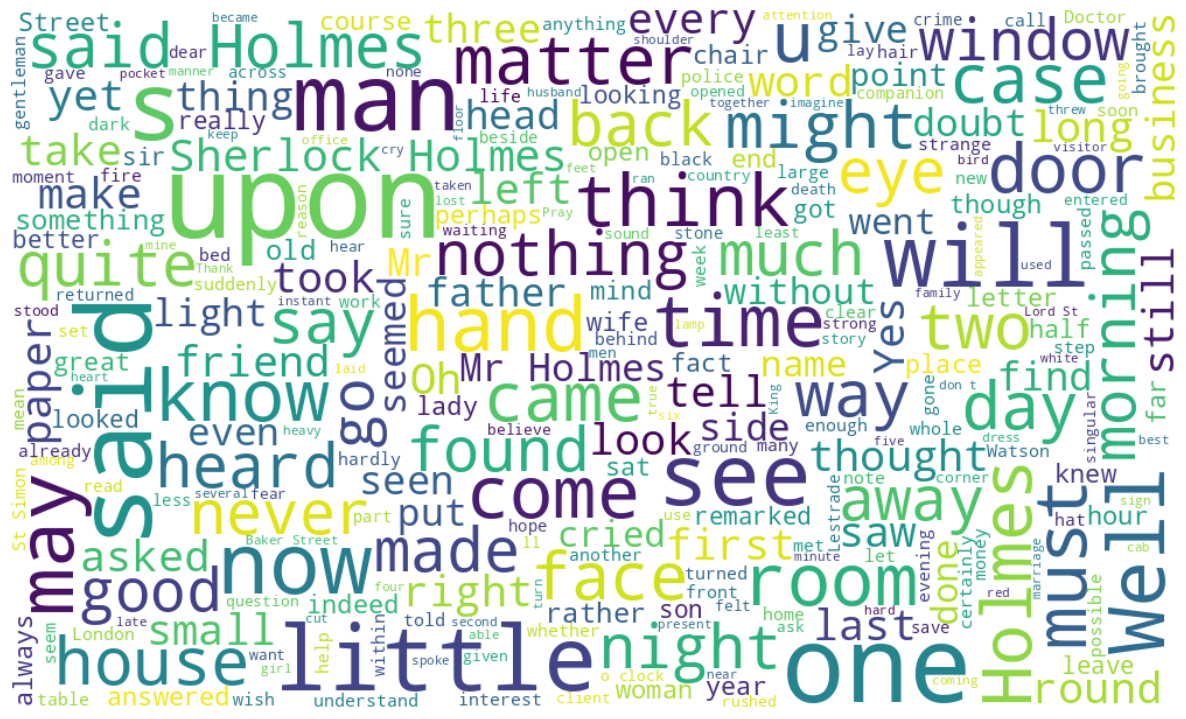

In [12]:

# 5.1  Basic word cloud

from wordcloud import WordCloud, STOPWORDS

if os.path.exists("data/sherlock_holmes.txt"):
    sherlock_text = read_text_file("data/sherlock_holmes.txt")
else:
    sherlock_text = " ".join(bbc_df["text"].values)
    print("Using BBC text as fallback")

def create_wordcloud(text, stop_words, apply_mask=None):
    """Create and display a word cloud."""
    if apply_mask is not None:
        wc = WordCloud(background_color="white", max_words=2000,
                       mask=apply_mask, stopwords=stop_words,
                       min_font_size=10, max_font_size=100,
                       contour_width=1, contour_color="steelblue")
    else:
        wc = WordCloud(min_font_size=10, max_font_size=100,
                       stopwords=stop_words,
                       width=1000, height=600, max_words=1000,
                       background_color="white",
                       colormap="viridis")
    wc.generate(text)

    plt.figure(figsize=(12, 7))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()
    return wc

wc = create_wordcloud(sherlock_text, set(STOPWORDS))


The word cloud immediately reveals the central characters and themes: **Holmes**, **said**, **man**, **upon**, **one**, **know** dominate. The prominence of "said" reflects the dialogue-heavy narrative style, while "upon" is characteristic of Victorian-era prose.

Word clouds are not rigorous analytical tools — they do not account for TF-IDF weighting or semantic similarity. But for **communication** purposes (executive summaries, blog posts, presentations), they are unmatched in instant visual impact.

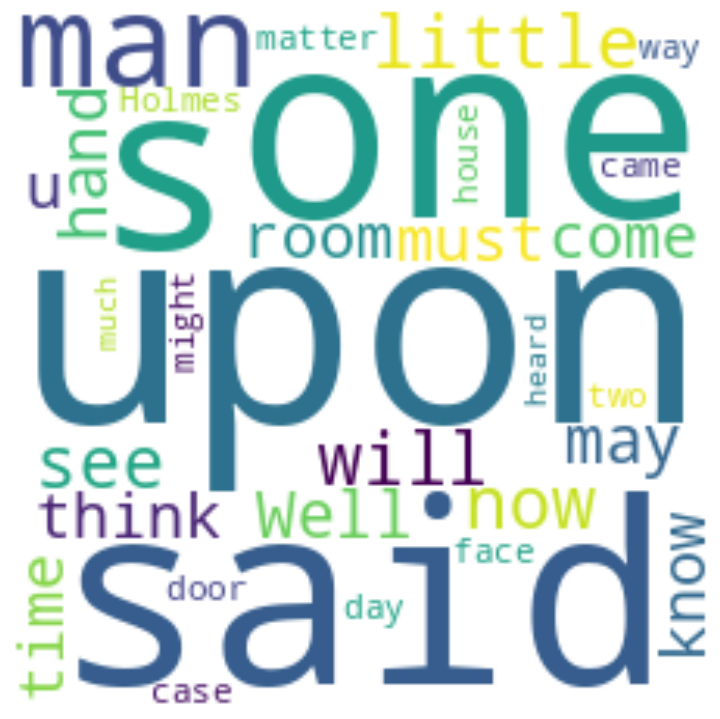

In [32]:

# 5.2  Masked word cloud (Sherlock silhouette)

from PIL import Image

if os.path.exists("data/images.png"):
    sherlock_mask = np.array(Image.open("data/images.png"))
    wc_masked = create_wordcloud(sherlock_text, set(STOPWORDS),
                                 apply_mask=sherlock_mask)
else:
    print("Sherlock mask image not available.")
    print("To create a masked word cloud, upload a silhouette PNG to data/sherlock.png")


The masked word cloud constrains the words to fit within the Sherlock Holmes silhouette, creating a visually striking image that combines content and form. The `contour_width` and `contour_color` parameters draw a border around the mask shape for better visibility.

**Production tip:** Masked word clouds make excellent assets for dashboards, social media, and printed reports. Use a high-contrast silhouette image (black shape on white background) for best results.

---

## Recipe 6 — Visualizing Topics from Gensim (pyLDAvis)

**pyLDAvis** creates interactive visualizations of LDA topic models. The left panel shows topics as circles positioned by inter-topic distance (computed via multidimensional scaling); the right panel shows the most relevant words for the selected topic. This lets you see both the **global structure** (which topics are similar?) and the **local details** (which words define each topic?).

We first train an LDA model (same as Chapter 6) and then visualize it.

In [14]:

# 6.1  Train LDA model on BBC data

from gensim.utils import simple_preprocess
from gensim.models.ldamodel import LdaModel
import gensim.corpora as corpora
from pprint import pprint

stop_words_lda = stopwords.words("english")
stop_words_lda.append("said")

def clean_text_lda(input_string):
    input_string = re.sub(r'[^\w\s]', ' ', input_string)
    input_string = re.sub(r'\d', '', input_string)
    input_list = simple_preprocess(input_string)
    return [w for w in input_list if w not in stop_words_lda]

bbc_lda = bbc_df.copy()
bbc_lda["text_clean"] = bbc_lda["text"].apply(clean_text_lda)

texts = bbc_lda["text_clean"].values
id_dict = corpora.Dictionary(texts)
corpus = [id_dict.doc2bow(t) for t in texts]

lda_model = LdaModel(
    corpus=corpus, id2word=id_dict, num_topics=5,
    chunksize=100, passes=20, random_state=42)

print("LDA model trained.\n")
pprint(lda_model.print_topics())


LDA model trained.

[(0,
  '0.012*"people" + 0.006*"would" + 0.006*"mobile" + 0.005*"new" + 0.005*"one" '
  '+ 0.005*"mr" + 0.005*"also" + 0.005*"could" + 0.004*"get" + 0.004*"phone"'),
 (1,
  '0.008*"game" + 0.008*"club" + 0.007*"england" + 0.006*"first" + '
  '0.005*"time" + 0.005*"year" + 0.005*"last" + 0.005*"back" + 0.005*"win" + '
  '0.004*"two"'),
 (2,
  '0.013*"film" + 0.010*"best" + 0.008*"year" + 0.006*"also" + 0.006*"show" + '
  '0.006*"one" + 0.006*"us" + 0.005*"music" + 0.005*"new" + 0.005*"awards"'),
 (3,
  '0.011*"us" + 0.009*"bn" + 0.008*"year" + 0.006*"company" + 0.005*"firm" + '
  '0.005*"market" + 0.005*"new" + 0.005*"also" + 0.004*"last" + '
  '0.004*"growth"'),
 (4,
  '0.028*"mr" + 0.011*"would" + 0.010*"election" + 0.009*"government" + '
  '0.009*"labour" + 0.007*"blair" + 0.007*"minister" + 0.006*"told" + '
  '0.005*"party" + 0.005*"brown"')]


In [15]:

# 6.2  Save model for reuse

from gensim.corpora import MmCorpus

os.makedirs("models/bbc_gensim", exist_ok=True)
lda_model.save("models/bbc_gensim/lda.model")
id_dict.save("models/bbc_gensim/id2word.dict")
MmCorpus.serialize("models/bbc_gensim/corpus.mm", corpus)
print("Model saved.")


Model saved.


In [25]:

# 6.3  Interactive pyLDAvis visualization

import pyLDAvis
import pyLDAvis.gensim_models as gensim_vis

lda_prepared = gensim_vis.prepare(lda_model, corpus, id_dict)

# Save as HTML for sharing
pyLDAvis.save_html(lda_prepared, "data/lda_gensim.html")
print("Saved interactive HTML to data/lda_gensim.html")

# Display in notebook
pyLDAvis.enable_notebook()
pyLDAvis.display(lda_prepared)


Saved interactive HTML to data/lda_gensim.html


The pyLDAvis visualization has two panels:

**Left panel — Intertopic Distance Map:** Each circle represents a topic, sized by its prevalence in the corpus. Topics positioned close together share similar word distributions; distant topics are more distinct. Ideally, you want well-separated circles with minimal overlap — this indicates the model has found distinct, coherent topics.

**Right panel — Top-30 Most Relevant Terms:** For the selected topic (hover or click), this bar chart shows the most relevant words. The blue bars show term frequency within the topic; the red bars show overall corpus frequency. The **relevance slider** ($\lambda$) controls the balance: at $\lambda = 1$ you see the most frequent words; at $\lambda = 0$ you see the most distinctive words. A value around $\lambda = 0.6$ often gives the most interpretable results.

---

## Recipe 7 — Visualizing Topics from BERTopic

BERTopic provides several built-in visualization methods that produce interactive Plotly charts. Unlike the LDA visualization (which shows word distributions), BERTopic visualizations leverage the underlying BERT embeddings to show **semantic relationships** between topics and documents.

In [26]:
import contextlib, io
from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired

docs = bbc_df["text"].values

representation_model = KeyBERTInspired()
topic_model = BERTopic(
    representation_model=representation_model,
    verbose=False)

with contextlib.redirect_stderr(io.StringIO()):
    topics, probs = topic_model.fit_transform(docs)

print(f"Topics discovered: {len(set(topics)) - 1}  (excluding outlier topic -1)")
print(f"Outlier documents: {topics.count(-1)}")
print()
print(topic_model.get_topic_info().head(10))

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Topics discovered: 45  (excluding outlier topic -1)
Outlier documents: 422

   Topic  Count                               Name  \
0     -1    422  -1_market_economy_economic_london   
1      0    185       0_what_mourinho_ferguson_who   
2      1    149     1_international_and_playing_is   
3      2    133            2_pop_singer_will_sales   
4      3    102     3_market_million_players_could   
5      4     86    4_champion_nadal_tournament_cup   
6      5     86              5_firm_been_was_being   
7      6     74          6_supporting_which_of_was   
8      7     64          7_tory_blair_gordon_hague   
9      8     63           8_viewers_but_which_said   

                                      Representation  \
0  [market, economy, economic, london, company, u...   
1  [what, mourinho, ferguson, who, chelsea, premi...   
2  [international, and, playing, is, players, but...   
3  [pop, singer, will, sales, robbie, than, be, a...   
4  [market, million, players, could, not, way, tv

Without restricting `nr_topics`, BERTopic discovers many more topics than the five BBC categories — typically 30--50 fine-grained topics. This is more realistic: "business" is not one topic but many (oil markets, tech stocks, housing prices, etc.). The `KeyBERTInspired` representation model produces cleaner topic labels by using BERT to select the most representative keywords, avoiding the stopword-heavy default labels.

In [27]:

# 7.2  Topic distance map

fig_topics = topic_model.visualize_topics()
fig_topics.show()


The topic distance map positions topics in 2D using UMAP dimensionality reduction on the topic embeddings. Each circle represents a topic, sized by the number of documents assigned to it. Hover over circles to see the topic keywords. Clusters of nearby circles indicate related subtopics that BERTopic kept separate because they have distinct vocabulary.

In [28]:

# 7.3  Topic hierarchy (dendrogram)

hierarchical_topics = topic_model.hierarchical_topics(bbc_df["text"])
fig_hier = topic_model.visualize_hierarchy(
    hierarchical_topics=hierarchical_topics)
fig_hier.show()


100%|██████████| 44/44 [00:39<00:00,  1.12it/s]


The hierarchical visualization shows which topics are most similar and would merge first if we reduced the number of topics. For example, several sport-related subtopics (football, rugby, athletics) cluster together before merging with the broader corpus. This hierarchy helps you decide on the right granularity: if two subtopics always merge early, they might be better treated as one.

Hover over the merge nodes to see the combined topic labels.

In [29]:

# 7.4  Top words per topic (bar chart)

fig_bar = topic_model.visualize_barchart(top_n_topics=15)
fig_bar.show()


The bar chart shows the c-TF-IDF scores for the top words in each topic. This is the most directly interpretable BERTopic visualization — you can quickly scan across topics and see what each one is about. The `KeyBERTInspired` representation ensures that the displayed words are semantically representative, not just statistically frequent.

In [30]:

# 7.5  Document map

fig_docs = topic_model.visualize_documents(docs)
fig_docs.show()


The document map plots every document as a point in 2D (using UMAP on the BERT embeddings), colored by topic assignment. Hover over points to read the actual document text. This visualization is excellent for:

- **Spotting outliers:** Documents colored as topic -1 are scattered between clusters
- **Verifying topic coherence:** Documents in the same cluster should be about the same theme
- **Identifying overlap:** Regions where clusters interpenetrate may indicate ambiguous documents or topics that should be merged

---

## Summary and Key Takeaways

This chapter demonstrated that NLP results become far more actionable when visualized. The key techniques and when to use them:

**For linguistic analysis:** displaCy's dependency parse and NER visualizations let you inspect how spaCy interprets individual texts — invaluable for debugging pipelines and explaining model behavior.

**For model evaluation:** Confusion matrices reveal systematic errors that aggregate metrics hide. Always generate one before declaring a classifier "done."

**For communication:** Word clouds provide instant visual impact for presentations. pyLDAvis creates interactive topic explorations for stakeholders who want to drill into the data themselves.

**For topic exploration:** BERTopic's suite of visualizations (topic maps, hierarchies, bar charts, document maps) provides the most comprehensive view of topic structure in your corpus.

The common thread: **visualization bridges the gap between technical output and human understanding.** A classification report is precise but requires expertise to interpret; a confusion matrix tells the same story in a format anyone can understand.